In [4]:
import os
import pandas as pd
import zstandard
import tiktoken

In [13]:
# encoder for gpt4, gpt3.5 and text-embedding-ada-002
enc = tiktoken.get_encoding("cl100k_base")

In [5]:
# uncompress the zstd file and read the first few lines of the test.jsonl file
with open(os.path.join('..', 'data', 'thepile', 'test.jsonl.zst'), 'rb') as fh:
    dctx = zstandard.ZstdDecompressor()
    with dctx.stream_reader(fh) as reader:
        # create a dataframe from the jsonl file
        df = pd.read_json(reader, lines=True)

In [6]:
#check the amount of memory the dataframe is using
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214584 entries, 0 to 214583
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    214584 non-null  object
 1   meta    214584 non-null  object
dtypes: object(2)
memory usage: 2.1 GB


In [7]:
df.shape

(214584, 2)

In [8]:
df.head()

,text,meta
0,Roman Catholic Diocese of Tambacounda\n\nThe R...,{'pile_set_name': 'Wikipedia (en)'}
1,Mud Hens pitcher Evan Reed charged with sexual...,{'pile_set_name': 'Pile-CC'}
2,One-year follow-up of patients treated for den...,{'pile_set_name': 'PubMed Abstracts'}
3,Optimizing medical practice using a computeriz...,{'pile_set_name': 'PubMed Abstracts'}
4,Q:\n\nShow message dialog\n\nIs it possible to...,{'pile_set_name': 'StackExchange'}


In [9]:
#convert the meta column of json objects into a "pile_set_name" column by extracting just the pile_set_name from the json object
df['pile_set_name'] = df['meta'].apply(lambda x: x['pile_set_name'])

In [10]:
df['pile_set_name'].value_counts()

Pile-CC              52790
OpenWebText2         32925
StackExchange        30378
PubMed Abstracts     29895
Github               18195
Wikipedia (en)       17511
USPTO Backgrounds    11415
PubMed Central        5911
FreeLaw               5101
ArXiv                 2407
DM Mathematics        1922
NIH ExPorter          1884
HackerNews            1632
Enron Emails          1010
OpenSubtitles          642
YoutubeSubtitles       342
Books3                 269
EuroParl               157
Gutenberg (PG-19)       80
PhilPapers              68
BookCorpus2             28
Ubuntu IRC              22
Name: pile_set_name, dtype: int64

In [11]:
#delete the meta column
del df['meta']


In [14]:
#convert the meta column of json objects into a "pile_set_name" column by extracting just the pile_set_name from the json object
#df['pile_set_name'] = df['meta'].apply(lambda x: x['pile_set_name'])
# encode each text sample with tiktoken
df['tokens'] = df['text'].apply(lambda x: len(enc.encode(x)))

In [15]:
# extract 4000 tokens from the text column and save into extract column
df['extract'] = df['text'].apply(lambda x: enc.decode(enc.encode(x)[:4000]))

In [19]:
del df['text']

In [26]:
#filter anythin with 0 or 1 tokens
df = df[df['tokens'] > 1]

In [30]:
df.shape

(214412, 3)

In [27]:
# write the dataframe to a csv file
#df.to_csv(os.path.join('..', 'data', 'thepile', 'test.csv'), index=False)
#df.to_csv(os.path.join('..', 'data', 'thepile', 'test-extract.csv'), index=False)
# df.to_csv(os.path.join('..', 'data', 'thepile', 'test-extract-filtered.csv'), index=False)

In [28]:
df.to_parquet(os.path.join('..', 'data', 'thepile', 'test-extract-filtered.parquet'), index=False, compression='gzip')

In [31]:
# copy just the pile_set_name and tokens to a new dataframe
df2 = df[['pile_set_name', 'tokens']].copy()
df2.to_parquet(os.path.join('..', 'data', 'thepile', 'test-counts-filtered.parquet'), index=False)

In [68]:
df3 = df[['pile_set_name', 'tokens']].copy()
df3['encoded'] = df['extract'].apply(lambda x: enc.encode(x)[0:4000])

In [69]:
df3.head()

,pile_set_name,tokens,encoded
0,Wikipedia (en),288,"[62080, 16879, 7923, 58744, 315, 59226, 582, 8..."
1,Pile-CC,496,"[44, 664, 473, 729, 42070, 45043, 36521, 11684..."
2,PubMed Abstracts,200,"[4054, 4771, 1833, 5352, 315, 6978, 12020, 369..."
3,PubMed Abstracts,149,"[22078, 318, 4954, 6593, 6725, 1701, 264, 6500..."
4,StackExchange,399,"[48, 1473, 7968, 1984, 7402, 271, 3957, 433, 3..."


In [93]:
# flatten the encoded column into a numpy array of int8
encoded = df3['encoded'].to_list()


In [100]:
# concatenate all of the encoded lists into a single np array
npencoded = np.concatenate(encoded)

In [102]:
npencoded.shape

(184190437,)

In [101]:
npencoded.max()

100255

In [103]:
#convert npencoded to uint16
npencoded = npencoded.astype(np.uint32)

In [104]:
npencoded.max()

100255

In [105]:
# write the encoded array to a binary file
with open(os.path.join('..', 'data', 'thepile', 'test-encoded-filtered.bin'), 'wb') as f:
    f.write(npencoded.tobytes())

In [70]:
df3.to_parquet(os.path.join('..', 'data', 'thepile', 'test-encoded-filtered.parquet'), index=False, compression='gzip')

In [35]:
# umap and stuff
import numpy as np
import matplotlib.pyplot as plt
import hdbscan
import umap
import json

In [36]:
name = "thepile/test-extract-filtered"

In [37]:
with open('../data/{name}-embeddings.json'.format(name=name), 'r') as f:
    metadata = json.load(f)

In [38]:
with open('../data/{name}-embeddings.bin'.format(name=name), 'rb') as f:
    embeddings = np.fromfile(f, dtype=np.float64)

In [39]:
#reshape the embeddings
embeddings = embeddings.reshape((len(metadata), metadata[0]["dimensions"]))

In [40]:
embeddings.shape

(214412, 1536)

In [41]:
df2.shape

(214412, 2)

In [50]:
# reduce dimensionality with umap
reducer = umap.UMAP(
    n_neighbors=50,
    min_dist=0.075,
    metric='cosine',
    random_state=42,
    n_components=2,
    verbose=True,
)

In [51]:
umap_embeddings = reducer.fit_transform(embeddings)

UMAP(angular_rp_forest=True, metric='cosine', min_dist=0.075, n_neighbors=50, random_state=42, verbose=True)
Sun May 21 12:00:43 2023 Construct fuzzy simplicial set
Sun May 21 12:00:43 2023 Finding Nearest Neighbors
Sun May 21 12:00:43 2023 Building RP forest with 28 trees
Sun May 21 12:00:51 2023 NN descent for 18 iterations
	 1  /  18
	 2  /  18
	Stopping threshold met -- exiting after 2 iterations
Sun May 21 12:01:15 2023 Finished Nearest Neighbor Search
Sun May 21 12:01:18 2023 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

Sun May 21 12:12:13 2023 Finished embedding


In [52]:
umap_embeddings.shape

(214412, 2)

In [61]:
# normalize the umap_embeddings to be between -1 and 1
umap_embeddings = (umap_embeddings - umap_embeddings.min()) / (umap_embeddings.max() - umap_embeddings.min())

/var/folders/sx/rrvr6l_d5x1_g46jxlx5ypfc0000gn/T/ipykernel_35450/3739994091.py:2: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1, cmap='Spectral')


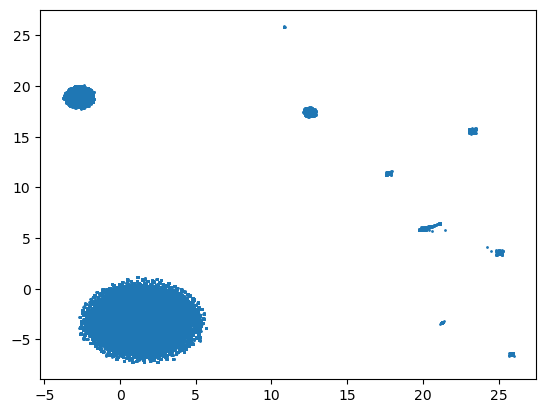

In [53]:
# plot embedding
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], s=1, cmap='Spectral')
plt.show()

In [156]:
def cluster(umap_embeddings, min_cluster_size=20, min_samples=10):
  # Create an HDBSCAN instance with custom parameters
  # cluster based on UMAP
  clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
  clusterer.fit(umap_embeddings)

  cluster_labels = clusterer.labels_
  return cluster_labels



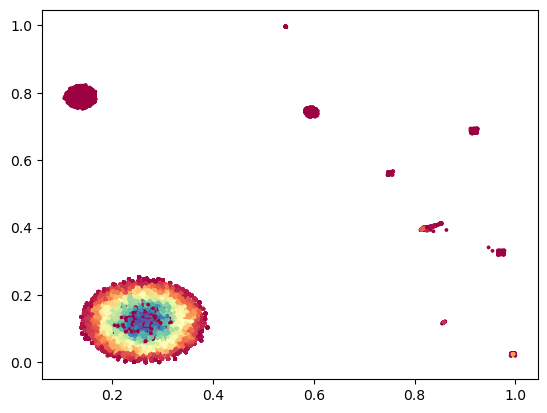

In [111]:
cluster_labels = cluster(umap_embeddings)
# plot embedding with cluster labels
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
# Find the centroids of the non-noise clusters
unique_labels = np.unique(cluster_labels)
  

In [112]:
unique_labels

array([  -1,    0,    1, ..., 1855, 1856, 1857])

In [142]:
def assign_clusters(umap_embeddings, cluster_labels):
    unique_labels = np.unique(cluster_labels)
    non_noise_labels = unique_labels[unique_labels != -1]
    centroids = [umap_embeddings[cluster_labels == label].mean(axis=0) for label in non_noise_labels]
    from scipy.spatial.distance import cdist
    # Assign noise points to the closest cluster centroid
    noise_points = umap_embeddings[cluster_labels == -1]
    closest_centroid_indices = np.argmin(cdist(noise_points, centroids), axis=1)

    # Update cluster_labels with the new assignments for noise points
    noise_indices = np.where(cluster_labels == -1)[0]
    new_assignments = [non_noise_labels[index] for index in closest_centroid_indices]
    assigned_labels = cluster_labels.copy()
    assigned_labels[noise_indices] = new_assignments
    return assigned_labels

In [ ]:
# plot embedding with cluster labels
assigned_labels = assign_clusters(umap_embeddings, cluster_labels)
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=assigned_labels, s=3, cmap='Spectral')


In [62]:
# add the embeddings to the df2 as x,y columns
df2['x'] = umap_embeddings[:, 0]
df2['y'] = umap_embeddings[:, 1]

# add the cluster labels to the df2 as cluster column
# df2['cluster'] = cluster_labels

In [63]:
df2.head()

,pile_set_name,tokens,x,y
0,Wikipedia (en),288,0.820147,0.399454
1,Pile-CC,496,0.819051,0.398790
2,PubMed Abstracts,200,0.814230,0.394458
3,PubMed Abstracts,149,0.814387,0.396008
4,StackExchange,399,0.823351,0.393316


In [64]:
df2.to_parquet(os.path.join('..', 'data', 'thepile', 'test-counts-filtered-points.parquet'), index=False)

In [ ]:
# compute convex hull of x,y points in each cluster
from scipy.spatial import ConvexHull

def get_hull(df):
    points = df[['x', 'y']].to_numpy()
    hull = ConvexHull(points)
    return hull

hulls = df2.groupby('cluster').apply(get_hull)


In [ ]:
# plot the hulls on the umap plot
for hull in hulls:
    plt.plot(hull.points[hull.vertices, 0], hull.points[hull.vertices, 1], lw=2)

plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], c=cluster_labels, s=3, cmap='Spectral')
plt.show()


In [106]:
# lets load the manually selected cluster indices and create subsets to cluster

In [107]:
# load the json for cluster-b.json
with open('../data/thepile/cluster-b.json', 'r') as f:
    cluster_b = json.load(f)

In [113]:
# select the subset of umap_embeddings thats in cluster_b
umap_embeddings_b = umap_embeddings[cluster_b]

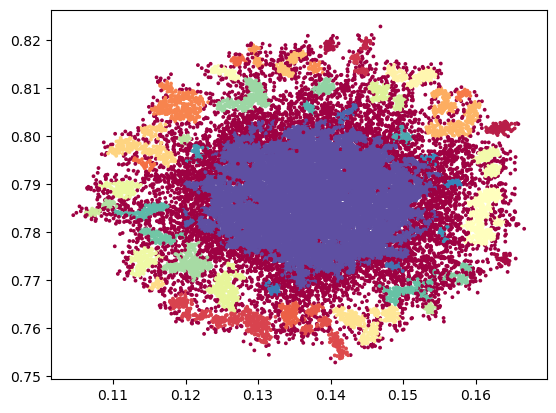

In [139]:
cluster_labels_b = cluster(umap_embeddings_b, min_cluster_size=25, min_samples=13)
# plot embedding with cluster labels
plt.scatter(umap_embeddings_b[:, 0], umap_embeddings_b[:, 1], c=cluster_labels_b, s=3, cmap='Spectral')
  

In [140]:
unique_labels_b = np.unique(cluster_labels_b)

In [141]:
unique_labels_b

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32,
       33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49,
       50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

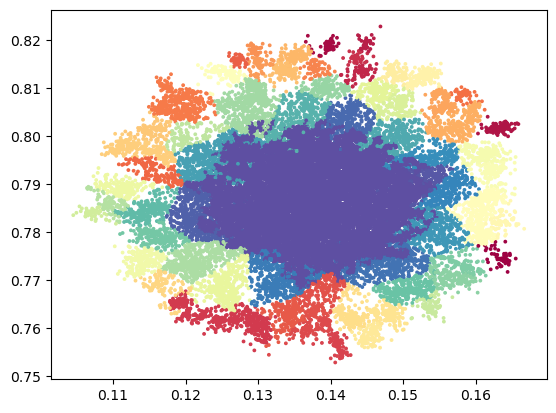

In [143]:
# plot embedding with cluster labels
assigned_labels_b = assign_clusters(umap_embeddings_b, cluster_labels_b)
plt.scatter(umap_embeddings_b[:, 0], umap_embeddings_b[:, 1], c=assigned_labels_b, s=3, cmap='Spectral')


In [158]:
# load json files and concat them 
clusters = ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j']
cluster_indices = []
for cluster_name in clusters:
    with open('../data/thepile/cluster-{cluster}.json'.format(cluster=cluster_name), 'r') as f:
        indices = json.load(f)
        # concat the indices array to cluster_indices
        cluster_indices = cluster_indices + indices


In [159]:
len(cluster_indices)

48426

In [160]:
# cluster_a is the indices not in cluster_indices
umap_embeddings_a = umap_embeddings[~np.isin(np.arange(len(umap_embeddings)), cluster_indices)]

In [161]:
umap_embeddings_a

array([[0.23501845, 0.09935459],
       [0.24330536, 0.15208992],
       [0.17615403, 0.10929867],
       ...,
       [0.25317994, 0.07196969],
       [0.3089494 , 0.13834012],
       [0.31644443, 0.18866765]], dtype=float32)

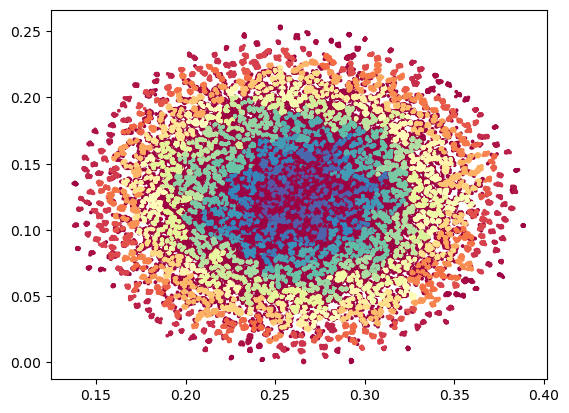

In [162]:
cluster_labels_a = cluster(umap_embeddings_a, min_cluster_size=25, min_samples=13)
# plot embedding with cluster labels
plt.scatter(umap_embeddings_a[:, 0], umap_embeddings_a[:, 1], c=cluster_labels_a, s=3, cmap='Spectral')
  

In [163]:
unique_labels = np.unique(cluster_labels_a)

In [ ]:
uniq